In [1]:
remotes::install_github("peeter-t2/digar.txts",lib="R_pckg/",upgrade="never")
library(digar.txts,lib.loc="R_pckg/")

* checking for file ‘/tmp/RtmpAH8EaJ/remotesa5e049d82a6a/peeter-t2-digar.txts-b87e10a/DESCRIPTION’ ... OK
* preparing ‘digar.txts’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted ‘LazyData’ from DESCRIPTION
* building ‘digar.txts_0.0.0.9100.tar.gz’
Warning in sprintf(gettext(fmt, domain = domain), ...) :
  one argument not used by format 'invalid uid value replaced by that for user 'nobody''



Loading required package: data.table



In [2]:
library(tidyverse)
install.packages('tidytext', lib='~/R_pckg')
library(tidytext, lib.loc='~/R_pckg')

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::transpose() masks data.table::transpose()



In [3]:
all_issues <- get_digar_overview()

[1] "Issue metadata read"


In [4]:
valiseesti_ajalehed <- all_issues %>%
    filter(DocumentType=="NEWSPAPER") %>%
    filter(keyid=="estdagbladet" | keyid=="eestiteatajastock" | keyid=="stockholmstid" | keyid=="teatajapoliit" | keyid=="valiseesti" | keyid=="eestipost" | keyid=="vabaeestlane" | keyid=="vabaeestisona" | keyid=="meiekodu" | keyid=="voitleja")

In [5]:
# Search for lemmas
searchterm <- "balti"
searchfile <- "balti_lemmas.txt"
do_subset_search(searchterm=searchterm, searchfile=searchfile, valiseesti_ajalehed, searchtype="lemmas", source="pages")

In [6]:
subset_meta <- get_subset_meta(valiseesti_ajalehed, source="pages")

Warning message in data.table::fread(cmd = x, fill = T):
“File '/tmp/RtmpAH8EaJ/filea5e0cf8615c' has size 0. Returning a NULL data.table.”


In [7]:
# Read lemma answers
texts <- fread("balti_lemmas.txt",header=F,sep="\t", quote="")[,.(id=V1,lemmas=V2)]
texts[,DocumentID:=str_extract(id,"[^\\.]+")]
fileids_w_meta <- texts %>% select(id, DocumentID) %>% left_join(valiseesti_ajalehed %>% select(keyid,year,month,DocumentID, zippath_sections,zippath_pages),by=c("DocumentID"))

In [8]:
# Get matching files and merge with document
get_matching_files(fileids_w_meta,"balti_text_via_lemmas.txt","pages","text")
texts_matching <- fread("balti_text_via_lemmas.txt",header=F,sep="\t", quote="")[,.(id=V1,txt=V2)]
text_and_lemmas <- merge(texts,texts_matching,by="id")

In [9]:
sonad_aastad_balti <- fileids_w_meta %>% 
  count(year) %>% mutate(set="balti")

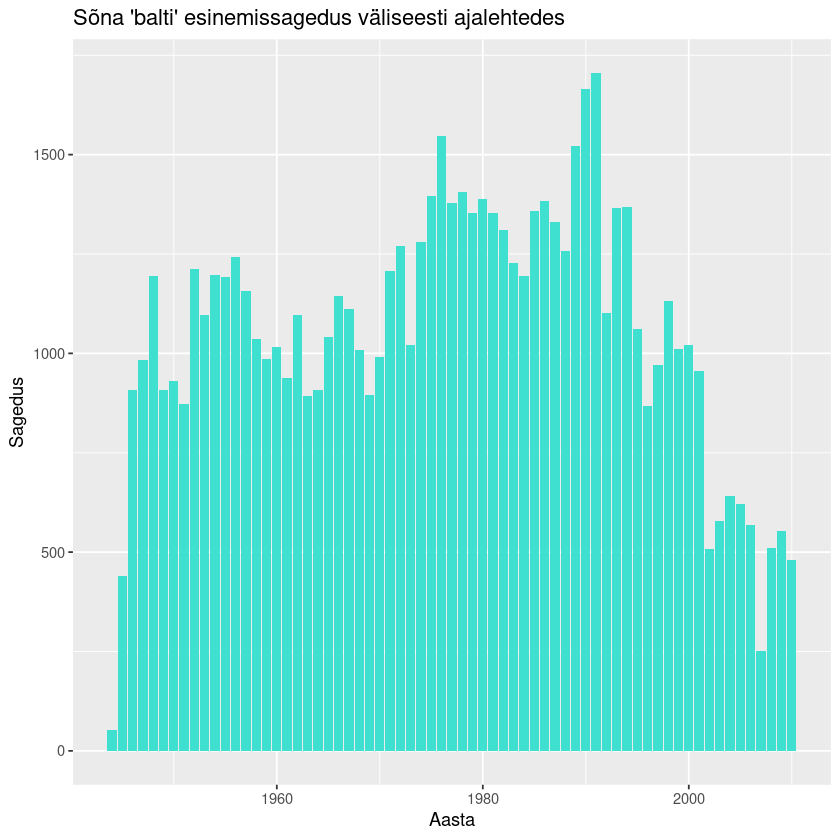

In [10]:
ggplot(data = sonad_aastad_balti, aes(x = year, y = n)) +
  geom_bar(stat = "identity", fill = "turquoise") +
  labs(x = "Aasta",
       y = "Sagedus",
       title = "Sõna 'balti' esinemissagedus väliseesti ajalehtedes")

In [11]:
balti_concs <- get_concordances(searchterm=searchterm,texts=texts,before=50,after=50,txt="lemmas",id="id")

In [56]:
# tekstifailiks tegemine
balti_concs2 <- balti_concs[, !c("id","nr","begin","end", "DocumentID")]

write.table(balti_concs2, "balti_concs.txt", sep="\t", quote = F, row.names = F)

In [12]:
balti_trigrammid <- balti_concs %>% 
  unnest_tokens(word, context, token = "ngrams", n = 3, n_min = 3) %>% 
  count(word,sort=T)

In [16]:
head(balti_trigrammid, 20)

word,n
<chr>,<int>
ja teine balti,2591
teine balti riik,2405
kolm balti riik,2233
liidu liidud liit,2199
eesti ja teine,1968
balti riik küsimus,1903
n liidu liidud,1632
balti riik ja,1452
de baltiska baltiskas,1360


In [17]:
balti_ngrammid <- balti_concs %>% 
  unnest_tokens(word, context, token = "ngrams", n = 3, n_min = 2) %>% 
  count(word,sort=T)

In [18]:
head(balti_ngrammid, 20)

word,n
<chr>,<int>
balti riik,35685
balti rahvas,10925
kolm balti,4841
ja balti,4318
teine balti,4287
balti vabariik,3680
ja teine,3428
olema balti,3348
ka balti,3339


In [19]:
searchterm2 <- "läti"
searchfile2 <- "lati_lemmas.txt"
do_subset_search(searchterm=searchterm2, searchfile=searchfile2, valiseesti_ajalehed, searchtype="lemmas", source="pages")

In [20]:
texts <- fread("lati_lemmas.txt",header=F,sep="\t", quote="")[,.(id=V1,lemmas=V2)]
texts[,DocumentID:=str_extract(id,"[^\\.]+")]
fileids_w_meta2 <- texts %>% select(id, DocumentID) %>% left_join(valiseesti_ajalehed %>% select(keyid,year,month,DocumentID, zippath_sections,zippath_pages),by=c("DocumentID"))

In [22]:
lati_concs <- get_concordances(searchterm=searchterm2,texts=texts,before=50,after=50,txt="lemmas",id="id")

In [23]:
lati_trigrammid <- lati_concs %>% 
  unnest_tokens(word, context, token = "ngrams", n = 3, n_min = 3) %>% 
  count(word,sort=T)

In [24]:
head(lati_trigrammid, 20)

word,n
<chr>,<int>
läti ja leedu,3687
eesti läti ja,3044
eesti ja läti,1564
eesti läti leedu,467
läti ja eesti,339
ja inglise keel,290
läti leedu ja,286
läti ja inglise,283
ja leedu rahvas,275


In [25]:
lati_ngrammid <- lati_concs %>% 
  unnest_tokens(word, context, token = "ngrams", n = 3, n_min = 2) %>% 
  count(word,sort=T)

In [26]:
head(lati_ngrammid, 20)

word,n
<chr>,<int>
läti ja,5327
eesti läti,4105
ja leedu,3898
läti ja leedu,3687
ja läti,3094
eesti läti ja,3044
eesti ja,1854
läti keel,1650
eesti ja läti,1564


In [27]:
searchterm3 <- "leedu"
searchfile3 <- "leedu_lemmas.txt"
do_subset_search(searchterm=searchterm3, searchfile=searchfile3, valiseesti_ajalehed, searchtype="lemmas", source="pages")

In [28]:
texts <- fread("leedu_lemmas.txt",header=F,sep="\t", quote="")[,.(id=V1,lemmas=V2)]
texts[,DocumentID:=str_extract(id,"[^\\.]+")]
fileids_w_meta3 <- texts %>% select(id, DocumentID) %>% left_join(valiseesti_ajalehed %>% select(keyid,year,month,DocumentID, zippath_sections,zippath_pages),by=c("DocumentID"))

In [29]:
leedu_concs <- get_concordances(searchterm=searchterm3,texts=texts,before=50,after=50,txt="lemmas",id="id")

In [30]:
leedu_trigrammid <- leedu_concs %>% 
  unnest_tokens(word, context, token = "ngrams", n = 3, n_min = 3) %>% 
  count(word,sort=T)

In [31]:
head(leedu_trigrammid, 20)

word,n
<chr>,<int>
lätlane ja leedulane,4743
läti ja leedu,3762
eestlane lätlane ja,2998
eesti läti ja,2568
eestlane lätlane leedulane,513
ja leedulane olema,483
eesti läti leedu,470
lätlane leedulane ja,359
ja leedu rahvas,328


In [32]:
leedu_ngrammid <- leedu_concs %>% 
  unnest_tokens(word, context, token = "ngrams", n = 3, n_min = 2) %>% 
  count(word,sort=T)

In [33]:
head(leedu_ngrammid, 20)

word,n
<chr>,<int>
ja leedulane,6141
lätlane ja,5451
ja leedu,5201
lätlane ja leedulane,4743
läti ja,4205
läti ja leedu,3762
eestlane lätlane,3712
eesti läti,3227
eestlane lätlane ja,2998


In [34]:
rootsi_ajalehed <- all_issues %>%
    filter(DocumentType=="NEWSPAPER") %>%
    filter(keyid=="estdagbladet" | keyid=="eestiteatajastock" | keyid=="stockholmstid" | keyid=="teatajapoliit" | keyid=="valiseesti")

In [35]:
searchterm <- "balti"
searchfile <- "balti_lemmas_rootsi.txt"
do_subset_search(searchterm=searchterm, searchfile=searchfile, rootsi_ajalehed, searchtype="lemmas", source="pages")

In [36]:
texts <- fread("balti_lemmas_rootsi.txt",header=F,sep="\t", quote="")[,.(id=V1,lemmas=V2)]
texts[,DocumentID:=str_extract(id,"[^\\.]+")]
fileids_w_meta4 <- texts %>% select(id, DocumentID) %>% left_join(rootsi_ajalehed %>% select(keyid,year,month,DocumentID, zippath_sections,zippath_pages),by=c("DocumentID"))

In [37]:
balti_concs_rootsi <- get_concordances(searchterm=searchterm,texts=texts,before=50,after=50,txt="lemmas",id="id")

In [38]:
balti_trigrammid_rootsi <- balti_concs_rootsi %>% 
  unnest_tokens(word, context, token = "ngrams", n = 3, n_min = 3) %>% 
  count(word,sort=T)

In [61]:
# tekstifailiks tegemine
balti_concs_rootsi2 <- balti_concs_rootsi[, !c("id","nr","begin","end", "DocumentID")]

write.table(balti_concs_rootsi2, "balti_concs_rootsi.txt", sep="\t", quote = F, row.names = F)

In [39]:
head(balti_trigrammid_rootsi, 20)

word,n
<chr>,<int>
de baltiska baltiskas,1353
kolm balti riik,922
teine balti riik,885
ja teine balti,837
liidu liidud liit,821
eesti ja teine,627
baltiska baltiskas staterna,613
n liidu liidud,612
balti riik küsimus,604


In [40]:
kanada_ajalehed <- all_issues %>%
    filter(DocumentType=="NEWSPAPER") %>%
    filter(keyid=="vabaeestlane" | keyid=="voitleja")

In [41]:
searchterm <- "balti"
searchfile <- "balti_lemmas_kanada.txt"
do_subset_search(searchterm=searchterm, searchfile=searchfile, kanada_ajalehed, searchtype="lemmas", source="pages")

In [42]:
texts <- fread("balti_lemmas_kanada.txt",header=F,sep="\t", quote="")[,.(id=V1,lemmas=V2)]
texts[,DocumentID:=str_extract(id,"[^\\.]+")]
fileids_w_meta5 <- texts %>% select(id, DocumentID) %>% left_join(kanada_ajalehed %>% select(keyid,year,month,DocumentID, zippath_sections,zippath_pages),by=c("DocumentID"))

In [43]:
balti_concs_kanada <- get_concordances(searchterm=searchterm,texts=texts,before=50,after=50,txt="lemmas",id="id")

In [44]:
balti_trigrammid_kanada <- balti_concs_kanada %>% 
  unnest_tokens(word, context, token = "ngrams", n = 3, n_min = 3) %>% 
  count(word,sort=T)

In [62]:
# tekstifailiks tegemine
balti_concs_kanada2 <- balti_concs_kanada[, !c("id","nr","begin","end", "DocumentID")]

write.table(balti_concs_kanada2, "balti_concs_kanada.txt", sep="\t", quote = F, row.names = F)

In [45]:
head(balti_trigrammid_kanada, 20)

word,n
<chr>,<int>
liidu liidud liit,702
kolm balti riik,682
teine balti riik,596
ja teine balti,548
balti riik küsimus,508
n liidu liidud,495
balti riik ja,449
eesti ja teine,378
balti naine nõukogu,343


In [46]:
usa_ajalehed <- all_issues %>%
    filter(DocumentType=="NEWSPAPER") %>%
    filter(keyid=="vabaeestisona")

In [52]:
searchterm <- "balti"
searchfile <- "balti_lemmas_usa.txt"
do_subset_search(searchterm=searchterm, searchfile=searchfile, usa_ajalehed, searchtype="lemmas", source="pages")

In [53]:
texts <- fread("balti_lemmas_usa.txt",header=F,sep="\t", quote="")[,.(id=V1,lemmas=V2)]
texts[,DocumentID:=str_extract(id,"[^\\.]+")]
fileids_w_meta5 <- texts %>% select(id, DocumentID) %>% left_join(usa_ajalehed %>% select(keyid,year,month,DocumentID, zippath_sections,zippath_pages),by=c("DocumentID"))

In [54]:
balti_concs_usa <- get_concordances(searchterm=searchterm,texts=texts,before=50,after=50,txt="lemmas",id="id")

In [55]:
balti_trigrammid_usa <- balti_concs_usa %>% 
  unnest_tokens(word, context, token = "ngrams", n = 3, n_min = 3) %>% 
  count(word,sort=T)

In [56]:
head(balti_trigrammid_usa, 20)

word,n
<chr>,<int>
ja teine balti,1172
eesti ja teine,947
teine balti riik,892
balti riik küsimus,776
liidu liidud liit,646
kolm balti riik,591
n liidu liidud,509
balti riik ja,423
läti ja leedu,354


In [57]:
austraalia_ajalehed <- all_issues %>%
    filter(DocumentType=="NEWSPAPER") %>%
    filter(keyid=="meiekodu")

In [59]:
searchterm <- "balti"
searchfile <- "balti_lemmas_austraalia.txt"
do_subset_search(searchterm=searchterm, searchfile=searchfile, austraalia_ajalehed, searchtype="lemmas", source="pages")

# tagasi tuleb tühi fail, kuna Austraalia ajalehel ei ole lehekülgi